# imports && functions

In [91]:
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.io

In [302]:
def UPA_codebook_generator(Mx, My, Mz, over_sampling_x, over_sampling_y, over_sampling_z, ant_spacing):
    """
    Generate Uniform Planar Array (UPA) codebook similar to MATLAB implementation
    
    Parameters:
    -----------
    Mx, My, Mz : int
        Number of antenna elements in x, y, z directions
    over_sampling_x, over_sampling_y, over_sampling_z : int
        Oversampling factors
    ant_spacing : float
        Antenna element spacing
    
    Returns:
    --------
    F_CB : numpy array
        Codebook matrix
    all_beams : numpy array
        Beam indices
    """
    kd = 2 * np.pi * ant_spacing
    antx_index = np.arange(Mx)
    anty_index = np.arange(My)
    antz_index = np.arange(Mz)
    
    # Codebook sizes
    codebook_size_x = over_sampling_x * Mx
    codebook_size_y = over_sampling_y * My
    codebook_size_z = over_sampling_z * Mz
    
    # Quantized beam steering angles
    theta_qx = np.linspace(0, np.pi, codebook_size_x, endpoint=False)
    theta_qy = np.linspace(0, np.pi, codebook_size_y, endpoint=False)
    theta_qz = np.linspace(0, np.pi, codebook_size_z, endpoint=False)
    
    # Generate codebooks for each direction
    F_CBx = np.sqrt(1/Mx) * np.exp(-1j * kd * antx_index[:, np.newaxis] * np.cos(theta_qx))
    F_CBy = np.sqrt(1/My) * np.exp(-1j * kd * anty_index[:, np.newaxis] * np.cos(theta_qy))
    F_CBz = np.sqrt(1/Mz) * np.exp(-1j * kd * antz_index[:, np.newaxis] * np.cos(theta_qz))
    
    # Kronecker product to get full codebook
    F_CBxy = np.kron(F_CBy, F_CBx)
    F_CB = np.kron(F_CBz, F_CBxy)
    
    # Generate beam indices
    beams_x = np.arange(1, codebook_size_x + 1)
    beams_y = np.arange(1, codebook_size_y + 1)
    beams_z = np.arange(1, codebook_size_z + 1)
    
    Mxx_Ind = np.tile(beams_x, codebook_size_y * codebook_size_z)
    Myy_Ind = np.tile(np.repeat(beams_y, codebook_size_x), codebook_size_z)
    Mzz_Ind = np.repeat(beams_z, codebook_size_x * codebook_size_y)
    
    all_beams = np.column_stack([Mxx_Ind, Myy_Ind, Mzz_Ind])
    
    return F_CB, all_beams

def plot_pattern(vec):
    """
    Plot beam pattern for given vector
    
    Parameters:
    -----------
    vec : numpy array
        Input vector to plot (column vector)
    """
    My = vec.shape[0]
    over_sampling_y = 1000
    
    # Generate codebook
    F, _ = UPA_codebook_generator(1, My, 1, 1, over_sampling_y, 1, 0.5)
    F= np.round(F, 4)
    F= np.matrix(F)
    # Quantized angles
    theta_s = np.arange(0, np.pi, np.pi / (over_sampling_y * My))

    F_conj_T = F.H
    # Matrix-vector multiplication (projection)
    vec= np.round(vec,4)
    projection = F_conj_T @ vec
    # Squared magnitude (equivalent to abs(projection).^2)
    proj = np.square(np.abs(projection))

    # Polar plot
    plt.figure(figsize=(10, 8))
    for n in range(vec.shape[1]):
        plt.polar(theta_s, proj[:, n])
    
    plt.title('Beam Pattern')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Script

In [141]:
# examples : sac_NLOS_seed_0__2024-10-22_10-57-03 , TD3_LOS__2024-08-09_00-54-12
experiments_path = os.path.join('..', 'experiments', 'runs')
all_experiment = {} #experiment scores (% average EGC reached)
for experiment_folder in os.listdir('../experiments/runs/'):
    experiment_path = os.path.join(experiments_path, experiment_folder,'beamforming_gain_records')
    if os.path.exists(experiment_path):
        num_beams= len([f for f in os.listdir(experiment_path) if os.path.isfile(os.path.join(experiment_path, f))])
        beams_data = []
        for i in range(num_beams):
            filename = f'beam_{i}_gain_records.npy'
            filepath = os.path.join(experiment_path, filename)
            data = np.load(filepath)
            beams_data.append(data)
        beams_array = np.array(beams_data)
        average_beam = np.array (beams_data)[:,-2]/beams_array.max(axis=1) 
        average_beam = np.mean(average_beam)
        all_experiment[experiment_folder]={}
        all_experiment[experiment_folder]['average_egc_reached'] = average_beam
        if 'NLOS' in experiment_folder:
            all_experiment[experiment_folder]['scenario'] = 'NLOS'
        else:   
            all_experiment[experiment_folder]['scenario'] = 'LOS'
        all_experiment[experiment_folder]['num_beams'] = num_beams
    else:
        pass
def find_best_experiment(data, algorithm, num_beams, scenario):
    # Filter the dictionary based on the given criteria
    filtered_experiments = {
        key: value
        for key, value in data.items()
        if algorithm.lower() in key.lower()
        and value['num_beams'] == num_beams
        and value['scenario'] == scenario
    }

    # Find the experiment with the highest average_egc_reached
    if filtered_experiments:
        best_experiment = max(filtered_experiments, key=lambda x: filtered_experiments[x]['average_egc_reached'])
        return best_experiment, filtered_experiments[best_experiment]['average_egc_reached']
    else:
        return None, None

In [142]:
# Parameters
algorithm = "sac"  # Change to "SAC" or "DDPG" as needed
num_beams = 4
scenario = "NLOS"

# Find the best experiment
best_experiment, best_score = find_best_experiment(all_experiment, algorithm, num_beams, scenario)
if best_experiment:
    print(f"Best experiment: {best_experiment}")
    print(f"Average EGC reached: {best_score:.2%}")
else:
    print("No experiment matches the given criteria.")

Best experiment: sac_NLOS_seed_1__2024-10-18_12-17-29
Average EGC reached: 65.53%


In [143]:
experiment_name = 'sac_NLOS_seed_1__2024-10-18_12-17-29'
experiment_path = os.path.join(experiments_path, experiment_name)
experiment_beams_path = os.path.join(experiment_path, 'beamforming_gain_records')
if os.path.exists(experiment_path):
    num_files = len([f for f in os.listdir(experiment_beams_path) if os.path.isfile(os.path.join(experiment_beams_path, f))])
    print(f"Number of beams in the experiment: {num_files}")
else:
    num_files = 0

beams_data = []

# Load data from all numpy files
for i in range(num_files):
    filename = f'beam_{i}_gain_records.npy'
    filepath = os.path.join(experiment_beams_path, filename)
    data = np.load(filepath)
    beams_data.append(data)


Number of beams in the experiment: 4


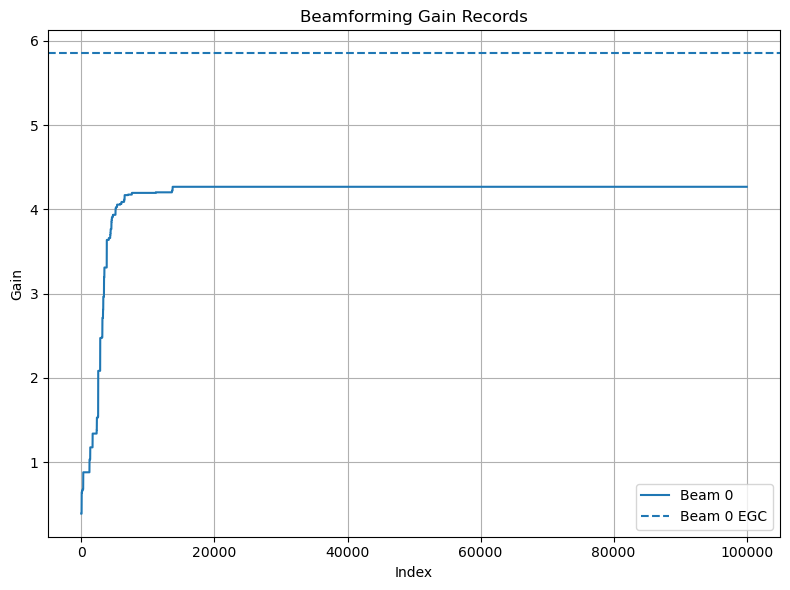

In [144]:
beam_index = 0  #beam index to plot

plt.figure(figsize=(8, 6))
plt.plot(beams_data[beam_index][:-1], label=f'Beam {beam_index}')
plt.axhline(y=beams_data[beam_index][-1], linestyle='--', 
                label=f'Beam {beam_index} EGC')

plt.xlabel('Index')
plt.ylabel('Gain')
plt.title('Beamforming Gain Records')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

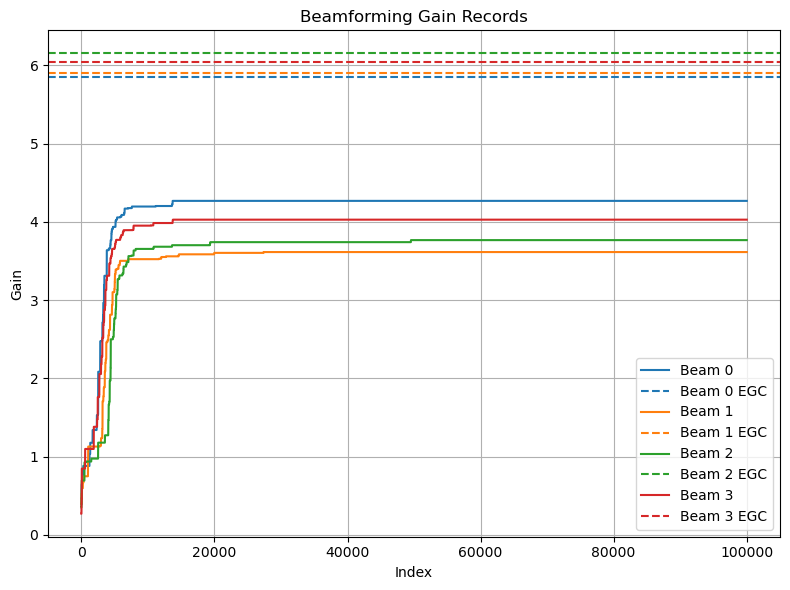

In [145]:
# Plotting
plt.figure(figsize=(8, 6))

for i, data in enumerate(beams_data):
    line, = plt.plot(data[:-1], label=f'Beam {i}')
    color = line.get_color()
    plt.axhline(y=data[-1], color=color, linestyle='--', 
                label=f'Beam {i} EGC')
plt.xlabel('Index')
plt.ylabel('Gain')
plt.title('Beamforming Gain Records')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

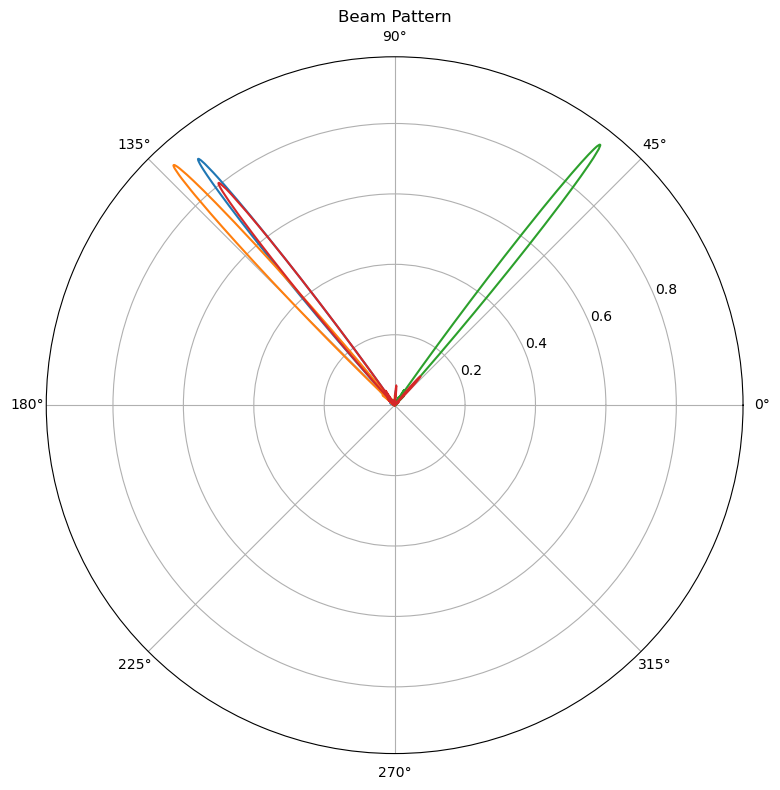

In [303]:
polar_graph_path = os.path.join(experiment_path,'beams','beam_codebook.mat')
mat_data = scipy.io.loadmat(polar_graph_path)
beams = mat_data['beams']
plot_pattern(beams.T)